In [28]:
# 载入 Python 依赖库
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "svg"

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchmetrics.regression import MeanAbsolutePercentageError
import pytorch_lightning
print(f"torch.__version__ = {torch.__version__}")
print(f"pytorch_lightning.__version__ = {pytorch_lightning.__version__}")

from torchkeras.losses import mspe
from torchkeras.lightmodel import LightModel

torch.random.seed()

torch.__version__ = 1.9.1
pytorch_lightning.__version__ = 1.7.3


2708019737514003046

df.head(): 
         date  confirmed_num  cured_num  dead_num
0  2020-01-24          830.0       34.0      25.0
1  2020-01-25         1287.0       38.0      41.0
2  2020-01-26         1975.0       49.0      56.0
3  2020-01-27         2744.0       51.0      80.0
4  2020-01-28         4515.0       60.0     106.0

df.tail(): 
          date  confirmed_num  cured_num  dead_num
42  2020-03-06        80552.0    53726.0    3042.0
43  2020-03-07        80651.0    55404.0    3070.0
44  2020-03-08        80695.0    57065.0    3097.0
45  2020-03-09        80735.0    58600.0    3119.0
46  2020-03-10        80754.0    59897.0    3136.0

df.shape: 
(47, 4)


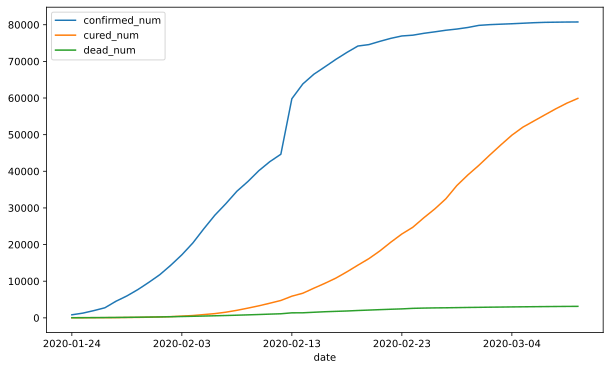

In [10]:
# 数据读取与查看
df = pd.read_csv("./data/covid-19.csv", sep = "\t")
print(f"df.head(): \n{df.head()}\n")
print(f"df.tail(): \n{df.tail()}\n")
print(f"df.shape: \n{df.shape}")

df.plot(
    x = "date",
    y = ["confirmed_num", "cured_num", "dead_num"],
    figsize = (10, 6),
)
plt.show()

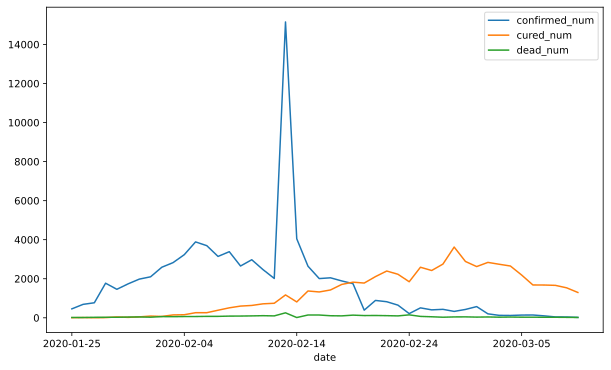

df_diff.head(): 
   confirmed_num  cured_num  dead_num
0          457.0        4.0      16.0
1          688.0       11.0      15.0
2          769.0        2.0      24.0
3         1771.0        9.0      26.0
4         1459.0       43.0      26.0


In [14]:
# 差分
df_data = df.set_index("date")
df_diff = df_data.diff(periods = 1).dropna()
df_diff = df_diff.reset_index("date")

df_diff.plot(
    x = "date",
    y = ["confirmed_num", "cured_num", "dead_num"],
    figsize = (10, 6),
)
plt.show()

df_diff = df_diff.drop("date", axis = 1).astype("float32")
print(f"df_diff.head(): \n{df_diff.head()}")

In [22]:
# 构建数据管道
WINDOW_SIZE = 8  # 用某日前 8 天窗口数据作为输入预测改日数据

class Covid19Dataset(Dataset):
    
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(df) - WINDOW_SIZE
    
    def __getitem__(self, index):
        # features
        x = self.df.loc[index:index + WINDOW_SIZE - 1, :]
        features = torch.tensor(x.values)
        # label
        y = self.df.loc[index + WINDOW_SIZE, :]
        label = torch.tensor(y.values)
        return (features, label)

ds_train = Covid19Dataset(df_diff)
dl_train = DataLoader(ds_train, batch_size = 38)  # 由于数据较小，可以将全部训练数据放入到一个 batch 中，提升性能
dl_val = dl_train  # dl_train 同时作为验证集

In [25]:
# 定义模型
class Block(nn.Module):
    
    def __init__(self):
        super(Block, self).__init__()
    
    def forward(self, x, x_input):
        x_out = torch.max(
            (1 + x) * x_input[:, -1, :], 
            torch.tensor(0.0)
        )
        return x_out

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size = 3, hidden_size = 3, num_layers = 5, batch_first = True)
        self.linear = nn.Linear(3, 3)
        self.block = Block()
        
    def forward(self, x_input):
        x = self.lstm(x_input)[0][:, -1, :]
        x = self.linear(x)
        y = self.block(x, x_input)
        return y

net = Net()
print(net)

Net(
  (lstm): LSTM(3, 3, num_layers=5, batch_first=True)
  (linear): Linear(in_features=3, out_features=3, bias=True)
  (block): Block()
)


In [30]:
# 训练模型
model = LightModel(
    net = net,
    loss_fn = mspe,
    metrics_dict = {"mape": MeanAbsolutePercentageError()},
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.03),
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        torch.optim.Adam(net.parameters(), lr = 0.03), 
        step_size = 10, 
        gamma = 0.0001
    ),
)
model_ckpt = pytorch_lightning.callbacks.ModelCheckpoint(
    monitor = "val_mape",
    save_top_k = 1,
    mode = "min",
)
early_stopping = pytorch_lightning.callbacks.EarlyStopping(
    monitor = "val_mape",
    patience = 3,
    mode = "min",
)

NameError: name 'optimizer' is not defined